## Train CNN based on Udacity

This notebook is to debug the outline training the CNN, specifically to ensure that the training data is as expected and the output from a training or testing run can be visualised.

Note that in order to train the CNN, this code will need to be run on GCP (or similar GPU-based server).


### Setup environments

#### Imports

Note that these imports are for the purposes of this notebook, they will be different when running `train.py` or `test.py`

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nn import nn
from nn import data_reader
from tracklets import generate_tracklet

#### Set up environment variables 


In [4]:
BATCH_SIZE = 1
DATA_DIR = '/vol/dataset2/Didi-Release-2/Tracklets/'
TRAINING_DATA_DIR = '/vol/didi/dataset2/Data'
LOGDIR = '/vol/training/logs'
TRAIN_DIR = '/vol/dataset2/Didi-Release-2/Train/'
PREDICT_DIR = '/vol/dataset2/Didi-Release-2/Predict/'
CSV='data.csv'
CHECKPOINT_EVERY = 100
NUM_STEPS = int(1e2)   # Run for 100 steps
CKPT_FILE = 'model.ckpt'
LEARNING_RATE = 1e-3
KEEP_PROB = 0.8
L2_REG = 0
EPSILON = 0.001
MOMENTUM = 0.9
BAG_CSV = 'data/training_data.csv'

### Setup model

This currently assumes u-net based model configured in nn/nn.py

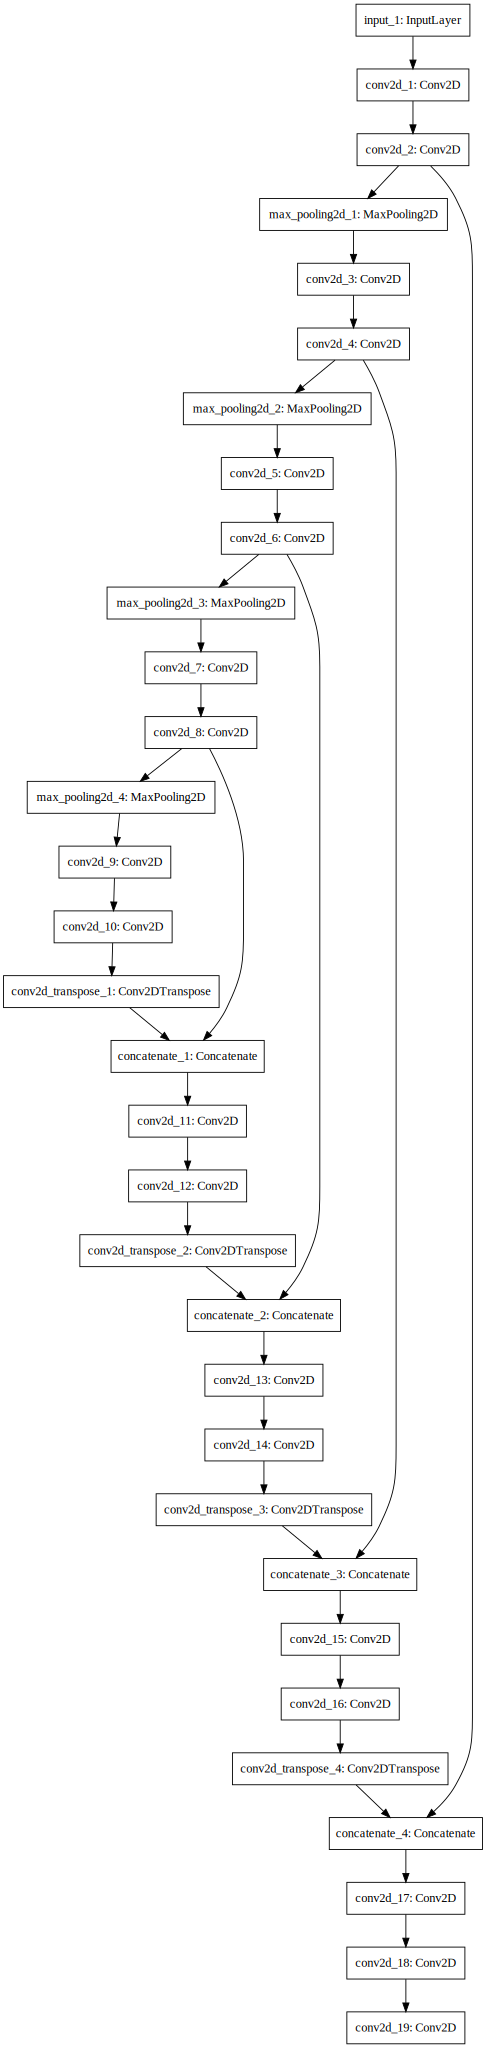

In [5]:
LossHistory, model = nn.top_nn()
# summary = model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Setup data_reader() for loading data

In [6]:
data_reader = data_reader.DataReader(BAG_CSV, DATA_DIR)

Processing training data: /vol/dataset2/Didi-Release-2/Tracklets/1/2
Parsing Tracklet file /vol/dataset2/Didi-Release-2/Tracklets/1/2/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets
Processing training data: /vol/dataset2/Didi-Release-2/Tracklets/1/3
Parsing Tracklet file /vol/dataset2/Didi-Release-2/Tracklets/1/3/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets
Processing training data: /vol/dataset2/Didi-Release-2/Tracklets/1/4_f
Parsing Tracklet file /vol/dataset2/Didi-Release-2/Tracklets/1/4_f/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets
Processing training data: /vol/dataset2/Didi-Release-2/Tracklets/1/6_f
Parsing Tracklet file /vol/dataset2/Didi-Release-2/Tracklets/1/6_f/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets
Processing training data: /vol/dataset2/Didi-Release-2/Tracklets/1/8_f
Parsing Tracklet file /vol/dataset2/Didi-Release-2/Tracklets/1/8_f/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tra

Load a single training sample to get things moving

In [14]:
BATCH_SIZE=8
xs, ys = data_reader.load_train_batch(batch_size=BATCH_SIZE)

load_train_batch(): batch = 8
load_train_batch(): pointcloud file = /vol/dataset2/Didi-Release-2/Tracklets/1/26/processed/lidar_top/1490992123603939000.npy
_predict_obj_y(): obj_size=[ 1.5748  1.4478  4.2418], track={'frame': 157, 'rotation': array([ 0., -0.,  0.]), 'translation': array([ 16.56682 ,  -8.150262,  -0.084599])}
load_train_batch(): pointcloud file = /vol/dataset2/Didi-Release-2/Tracklets/1/18/processed/lidar_top/1490991911019777000.npy
_predict_obj_y(): obj_size=[ 1.5748  1.4478  4.2418], track={'frame': 37, 'rotation': array([ 0., -0.,  0.]), 'translation': array([  4.26865400e+01,   4.58745700e+00,   2.25230000e-02])}
load_train_batch(): pointcloud file = /vol/dataset2/Didi-Release-2/Tracklets/1/2/processed/lidar_top/1490991287279295000.npy
_predict_obj_y(): obj_size=[ 1.5748  1.4478  4.2418], track={'frame': 141, 'rotation': array([ 0., -0.,  0.]), 'translation': array([ 9.087523,  0.716283, -0.490502])}
load_train_batch(): pointcloud file = /vol/dataset2/Didi-Release-2

Display info about the training data:

* xs = `pointcloud.npy` data based on the format created by `sensor_pipeline/extract_pointclouds.py`
* ys = mask of obstacle in (0,1) format, where 0=background and 1=obstacle (car)

In [15]:
print ('xs.shape={}'.format(xs.shape))
print ('ys.shape={}'.format(ys.shape))

xs.shape=(8, 400, 400, 8)
ys.shape=(8, 400, 400, 1)


Render the training mask and the respective point cloud image (generated by `pointcloud_utils/create_pointcloud_image.py`)

In [16]:
pcl_masks=np.array(ys[:,:,:,0], dtype=np.uint8)
print pcl_masks.shape
print BATCH_SIZE

(8, 400, 400)
8


In [17]:
#print (pcl_mask)
#print (np.nonzero(pcl_mask))
#print (pcl_mask[87:132, 184:208])

In [18]:
#timestamp = '1490991281474291000'    # First pointcloud in the bag
#pointcloud_image_file=os.path.join(DATA_DIR, 'processed', 'lidar_top_img', timestamp + '.png')

In [19]:
def draw_lidar_top(lidar):
    top_image = np.zeros((400,400),dtype=np.float32)

    for x in range(400):
        for y in range(400):
            pixel=0
            for z in range(8):
                if lidar[x,y,z] != 0:
                    pixel = 255
            top_image[x,y] = pixel

    top_image = np.dstack((top_image, top_image, top_image)).astype(np.uint8)
    return top_image

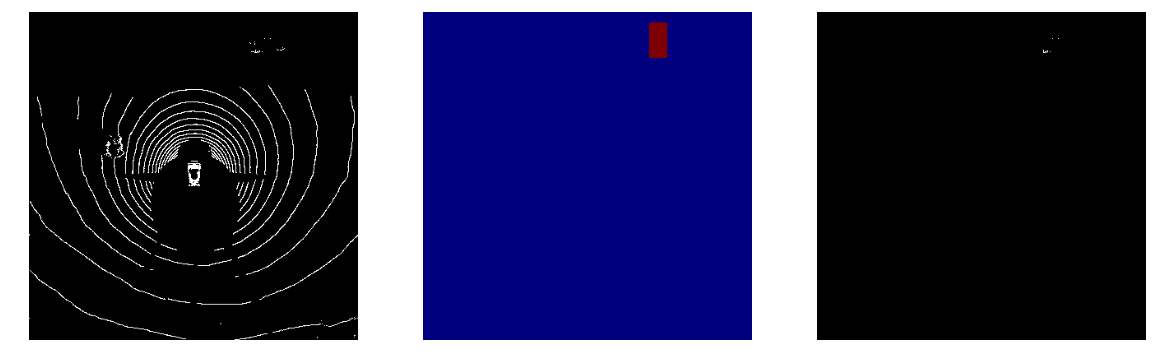

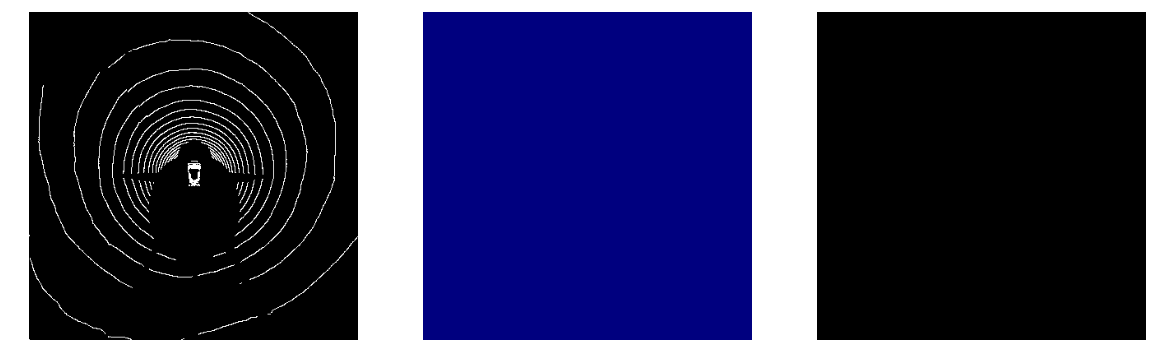

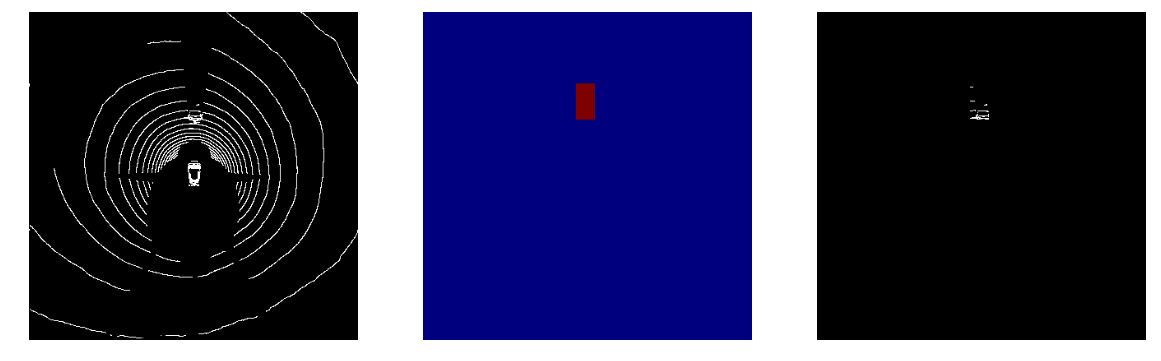

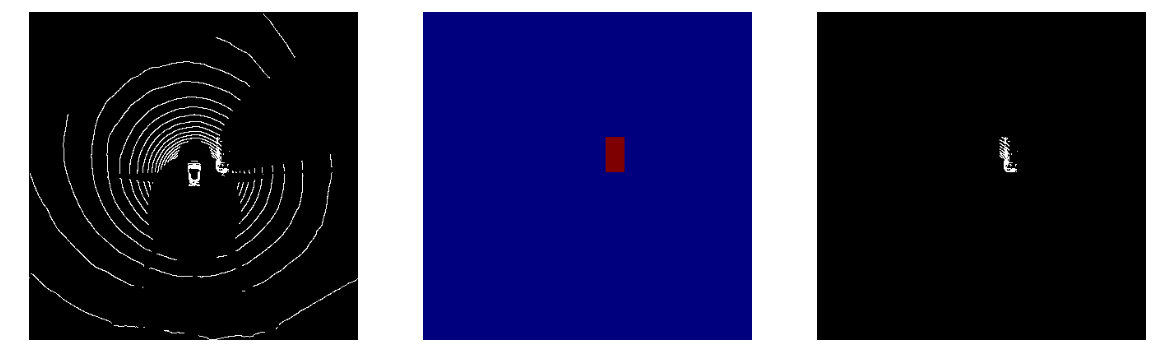

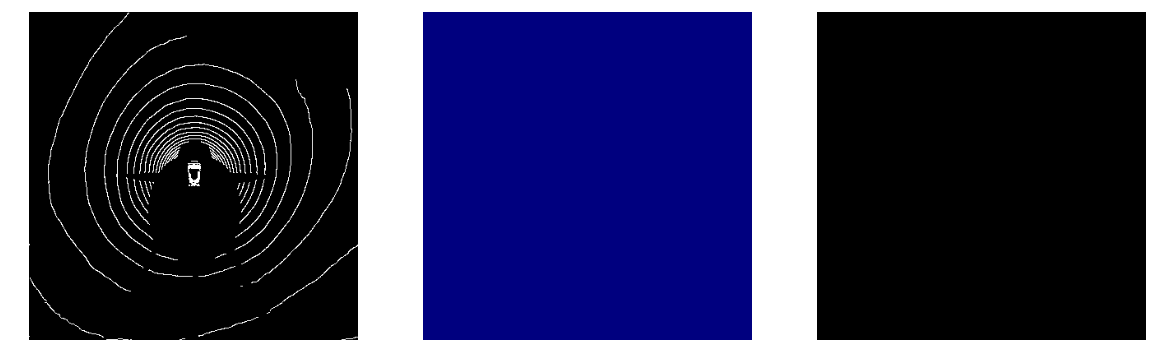

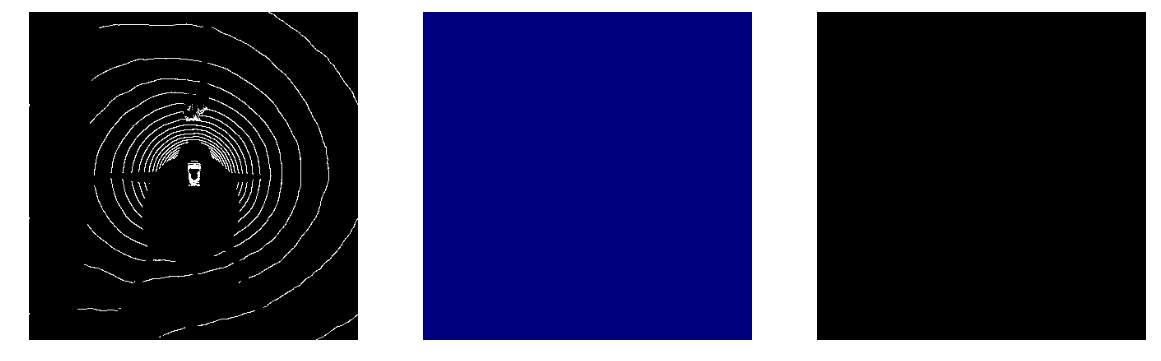

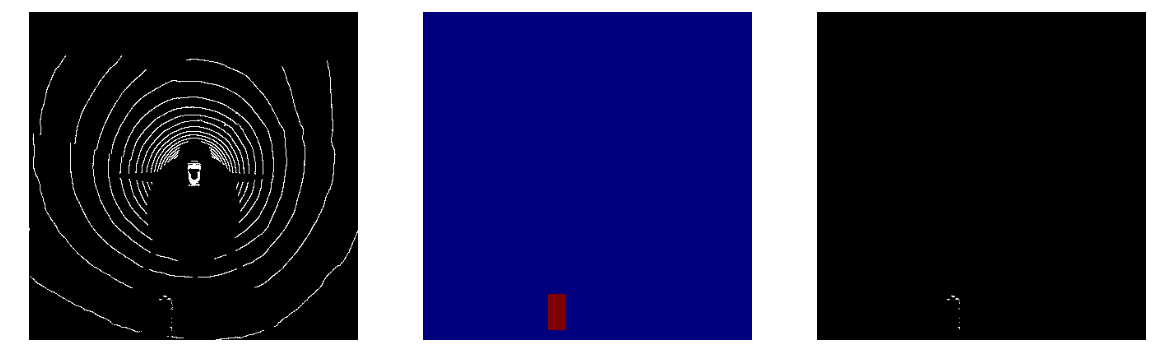

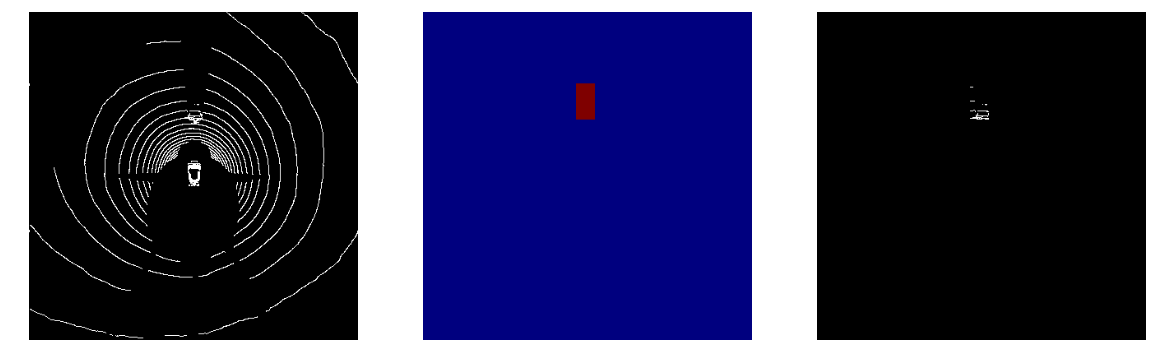

In [20]:
for i in range(BATCH_SIZE):
    plt.figure(figsize=(20,10))

    #pcl_image = cv2.imread(pointcloud_image_file,0)
    
    pcl_image = draw_lidar_top(xs[i])
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.imshow(pcl_image)

    plt.subplot(1,3,2)
    plt.axis("off")
    plt.imshow(pcl_masks[i])

    im = np.array(pcl_image,dtype=np.uint8)
    im_mask = np.array(pcl_masks[i],dtype=np.uint8)
    plt.subplot(1,3,3)
    plt.axis("off")
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.show()

### Collate all training examples 

In [119]:
bag_dataframe = pd.read_csv('./data/training_data.csv')
bag_dataframe['start_frame'].fillna(0, inplace=True)
bag_dataframe['end_frame'].fillna(-1, inplace=True)

training_bag_files = []
for idx, training_row in bag_dataframe.iterrows():
    bag = os.path.join(TRAINING_DATA_DIR, 'Tracklets', str(training_row.directory), str(training_row.bag) )
    training_bag_files.append(bag)
    
bag_dataframe['bag_directory'] = training_bag_files  
print (bag_dataframe)

    directory   bag  time_offset  start_frame  end_frame  \
0           1     2            0            0         -1   
1           1     3            0            0         -1   
2           1   4_f            0            0         -1   
3           1   6_f            0            0         -1   
4           1   8_f            0            0         -1   
5           1   9_f            0            0         -1   
6           1    10            0            0         -1   
7           1    11            0            0         -1   
8           1    13            0            0         -1   
9           1  14_f            0            0         -1   
10          1    15          -13            0         -1   
11          1    17          -12            0         -1   
12          1    18          -12            0         -1   
13          1    19          -12            0         -1   
14          1    23          -30            0         -1   
15          1    26          -30        

In [117]:
for idx, training_data in bag_dataframe.iterrows():
    training_dir = training_data.bag_directory
    

/vol/didi/dataset2/Data/Tracklets/1/2
/vol/didi/dataset2/Data/Tracklets/1/3
/vol/didi/dataset2/Data/Tracklets/1/4_f
/vol/didi/dataset2/Data/Tracklets/1/6_f
/vol/didi/dataset2/Data/Tracklets/1/8_f
/vol/didi/dataset2/Data/Tracklets/1/9_f
/vol/didi/dataset2/Data/Tracklets/1/10
/vol/didi/dataset2/Data/Tracklets/1/11
/vol/didi/dataset2/Data/Tracklets/1/13
/vol/didi/dataset2/Data/Tracklets/1/14_f
/vol/didi/dataset2/Data/Tracklets/1/15
/vol/didi/dataset2/Data/Tracklets/1/17
/vol/didi/dataset2/Data/Tracklets/1/18
/vol/didi/dataset2/Data/Tracklets/1/19
/vol/didi/dataset2/Data/Tracklets/1/23
/vol/didi/dataset2/Data/Tracklets/1/26
/vol/didi/dataset2/Data/Tracklets/1/26_2
/vol/didi/dataset2/Data/Tracklets/2/1
/vol/didi/dataset2/Data/Tracklets/2/2


    directory   bag  time_offset  start_frame  end_frame  \
0           1     2            0            0         -1   
1           1     3            0            0         -1   
2           1   4_f            0            0         -1   
3           1   6_f            0            0         -1   
4           1   8_f            0            0         -1   
5           1   9_f            0            0         -1   
6           1    10            0            0         -1   
7           1    11            0            0         -1   
8           1    13            0            0         -1   
9           1  14_f            0            0         -1   
10          1    15          -13            0         -1   
11          1    17          -12            0         -1   
12          1    18          -12            0         -1   
13          1    19          -12            0         -1   
14          1    23          -30            0         -1   
15          1    26          -30        

# Testing

This section tests the model to see how it performs visually

Load pre-trained weights. Note this filename will change after each training run.

In [22]:
weights='/vol/dataset2/Didi-Release-2/Train/model-final-step-999-val-2.ckpt'
model.load_weights(weights)

Pointcloud to test with:

In [23]:
print (xs.shape)

(1, 400, 400, 8)


In [24]:
predict = model.predict(xs, batch_size = 1)

Investigate output from prediction

In [25]:
print (predict.shape)
predict_image=np.array(255*predict[0,:,:,0], dtype=np.uint8)
print (predict_image.shape)

(1, 400, 400, 1)
(400, 400)


In [33]:
#print (np.nonzero(predict_image))
print (predict_image[87:132, 184:208])
print (np.argwhere(predict_image>0))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[]


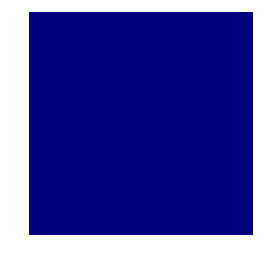

In [27]:
plt.axis("off")
plt.imshow(predict_image)
plt.show()

In [28]:
print pcl_image.shape
print pcl_mask.shape
print predict_image.shape

(400, 400)
(400, 400)
(400, 400)


In [31]:
pcl_image_colour = np.zeros((400,400,3))
pcl_image_colour.shape
pcl_image_colour[:,:,0] = pcl_image
pcl_image_colour[:,:,1] = pcl_image
pcl_image_colour[:,:,2] = pcl_image

(400, 400, 3)
(400, 400, 3)


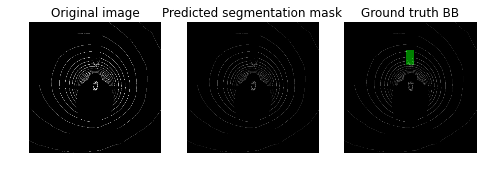

In [32]:
plt.figure(figsize=(100,50))

im = np.array(pcl_image_colour,dtype=np.uint8)
im_mask = np.array(255*pcl_mask,dtype=np.uint8)
im_pred = np.array(predict_image,dtype=np.uint8)
    
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
   
print rgb_mask_pred.shape
print rgb_mask_true.shape

img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Predicted segmentation mask')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img_true)
plt.title('Ground truth BB')
plt.axis('off')
plt.show()

